# Imports

In [1]:
import os
os.environ['TRANSFORMERS_CACHE'] = '/data/peskine/tmp/'
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [117]:
from PIL import Image
Image.MAX_IMAGE_PIXELS = None
import torch
from tqdm import tqdm, trange
import json
from transformers import AutoTokenizer
from mplug_owl.modeling_mplug_owl import MplugOwlForConditionalGeneration
from mplug_owl.processing_mplug_owl import MplugOwlImageProcessor, MplugOwlProcessor
import requests

In [130]:
import pandas as pd

In [189]:
import matplotlib.pyplot as plt
import seaborn as sns

# Model

In [2]:
# Load via Huggingface Style

pretrained_ckpt = 'MAGAer13/mplug-owl-llama-7b'
model = MplugOwlForConditionalGeneration.from_pretrained(
    pretrained_ckpt,
    torch_dtype=torch.bfloat16,
)
image_processor = MplugOwlImageProcessor.from_pretrained(pretrained_ckpt)
tokenizer = AutoTokenizer.from_pretrained(pretrained_ckpt)
processor = MplugOwlProcessor(image_processor, tokenizer)

/data/conda/mPLUG/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


install flash-attn first.


In [3]:
model = model.to('cuda')

# Data

In [256]:
json_file_path = '/data/peskine/hackathon/filtered_data.json'
with open(json_file_path, 'r') as j:
     contents = json.loads(j.read())

In [258]:
len(contents)

1101

In [252]:
filtered_data = {}
for k in contents:
    c = contents[k]
    if len(c['wiki_abs'])>50 and 'movement' in c['props'] and c['props']['instance of'] == ['painting'] and 'creator' in c['props'] and 'made from material' in c['props']:
        filtered_data[k] = c

In [255]:
with open('/data/peskine/hackathon/filtered_data.json', 'w') as f:
    json.dump(filtered_data, f)

In [304]:
small_dataset = []

available_movements = ['Baroque', 'mannerism', 'Romanticism', 'Impressionism', 'Realism']
counts = [0, 0, 0, 0, 0]

for c in tqdm(contents):
    m = contents[c]['props']['movement']
    
    if m[0] in available_movements and len(m)==1:
        i = available_movements.index(m[0])
        if counts[i]<10:
            small_dataset.append(c)
            counts[i]+=1
    

100%|██████████████████████████████████████████████| 1101/1101 [00:00<00:00, 607142.87it/s]


# Download pictures

In [333]:
for c in tqdm(small_dataset):
    pic_url = contents[c]['pic']
    
    #if not os.path.isfile('/data/peskine/hackathon/images/'+str(c)+'.png'):
    im = Image.open(urlopen(pic_url))
    basewidth = 500
    wpercent = (basewidth/float(im.size[0]))
    hsize = int((float(im.size[1])*float(wpercent)))
    img = im.resize((basewidth,hsize), Image.Resampling.LANCZOS)
    img.save('/data/peskine/hackathon/images/'+str(c)+'.png')
    
    

100%|██████████████████████████████████████████████████████| 50/50 [01:57<00:00,  2.36s/it]


In [317]:
for c in tqdm(contents):
    pic_url = contents[c]['pic']
    
    if not os.path.isfile('/data/peskine/hackathon/images/'+str(c)+'.png'):
        image = Image.open(urlopen(pic_url))
        image.save('/data/peskine/hackathon/images/'+str(c)+'.png')
    
    

  0%|                                                   | 2/1101 [00:10<1:32:16,  5.04s/it]


KeyboardInterrupt: 

# Prompt

In [307]:
relations = ['creator', 'movement'] #fabrication method, made from material

In [308]:
prompt_dict = {}
prompt_dict['movement'] = "Which movement does this painting belong to?"
prompt_dict['creator'] = "Who painted this painting?"
#prompt_dict['made from material'] = "Which material does this painting use? (e.g. oil paint, canvas, wax paint, ink, marble, bronze, etc)"

In [ ]:
download_required = False

technique = 'both' #image, both, text
for r in relations:
    replies = []
    gt = []
    prompt_list = []
    Qs = []
    for c in tqdm(small_dataset):
        Qs.append(c)
        # We use a human/AI template to organize the context as a multi-turn conversation.
        # <image> denotes an image placehold.
        if technique == 'image':
            prompts = [
            '''The following is a conversation between a curious human and an art historian assistant about paintings. The art historian gives helpful, detailed, and polite answers to the user's questions.
Human: <image>
Human: %s
Art Historian: '''%(prompt_dict[r])]
        elif technique == 'text':
            prompts = [
            '''The following is a conversation between a curious human and an art historian assistant about paintings. The art historian gives helpful, detailed, and polite answers to the user's questions.
Painting info: %s
Human: %s
Art Historian: '''%(contents[c]['wiki_abs'], prompt_dict[r])]
            
        elif technique == 'both':
            prompts = [
            '''The following is a conversation between a curious human and an art historian assistant about paintings. The art historian gives helpful, detailed, and polite answers to the user's questions.
Painting info: %s
Human: <image>
Human: %s
Art Historian: '''%(contents[c]['wiki_abs'], prompt_dict[r])]            
        # The image paths should be placed in the image_list and kept in the same order as in the prompts.
        # We support urls, local file paths and base64 string. You can custom the pre-process of images by modifying the mplug_owl.modeling_mplug_owl.ImageProcessor
        
        # generate kwargs (the same in transformers) can be passed in the do_generate()
        generate_kwargs = {
            'do_sample': True,
            'top_k': 5,
            'temperature':0.01,
            'max_length': 512
        }
        prompt_list.append(prompts[0])
        if download_required:
            im = Image.open(urlopen(contents[c]['pic']))
            basewidth = 500
            wpercent = (basewidth/float(im.size[0]))
            hsize = int((float(im.size[1])*float(wpercent)))
            img = im.resize((basewidth,hsize), Image.Resampling.LANCZOS)
        else:
            im = Image.open('/data/peskine/hackathon/images/'+str(c)+'.png')
            basewidth = 500
            wpercent = (basewidth/float(im.size[0]))
            hsize = int((float(im.size[1])*float(wpercent)))
            img = im.resize((basewidth,hsize), Image.Resampling.LANCZOS)
        images = [img]
        inputs = processor(text=prompts, images=images, return_tensors='pt')
        inputs = {k: v.bfloat16() if v.dtype == torch.float else v for k, v in inputs.items()}
        inputs = {k: v.to(model.device) for k, v in inputs.items()}
        with torch.no_grad():
            res = model.generate(**inputs, **generate_kwargs)
        sentence = tokenizer.decode(res.tolist()[0], skip_special_tokens=True)
        replies.append(sentence)
    df = pd.DataFrame()
    df['Q'] = Qs
    df['prompts'] = prompt_list
    df['replies'] = replies
    
    df.to_csv('/data/peskine/hackathon/results/'+str(technique)+'/'+str(r)+'.csv', index=False)


 62%|█████████████████████████████████▍                    | 31/50 [00:20<00:13,  1.43it/s]

In [428]:
movements = [['Baroque'], ['mannerism', 'Mannerism'], ['Romanticism', 'Romantic'], ['Impressionism', 'Impressionist'], ['Realism', 'Realist']]

In [470]:
movements = [['Baroque'], ['mannerism', 'Mannerism'], ['Romanticism', 'Romantic'], ['Impressionism', 'Impressionist'], ['Realism', 'Realist']]
technique = 'both' #text, image, both

for r in relations[1:]:
    gt = []
    for c in tqdm(small_dataset):
        gt.append(contents[c]['props'][r])
        
    df = pd.read_csv('/data/peskine/hackathon/results/'+technique+'/'+str(r)+'.csv')
    replies = df['replies'].tolist()
    
    answers = []
    for i in range(0, len(replies)):
        a = []
        for g in gt[i]:
            m_ind = available_movements.index(g)
            for m in movements[m_ind]:
                if m in replies[i]:
                    a.append(g)
                    break
        answers.append(a)
    
    correct =0
    for i in range(0, len(answers)):
        if answers[i] == gt[i]:
            correct+=1
        
    print(r, correct/len(small_dataset))

100%|██████████████████████████████████████████████████| 50/50 [00:00<00:00, 247597.64it/s]

movement 0.68


In [422]:
df = pd.read_csv('/data/peskine/hackathon/results/image/movement.csv')

In [426]:
r = df['replies'].tolist()
for i in range(0, len(small_dataset)):
    data = contents[small_dataset[i]]['props']['movement']
    if data[0] not in r[i]:
        print(data, r[i])


['Impressionism'] This painting belongs to the Post-Impressionist movement.
['Impressionism'] This painting belongs to the Impressionist movement.
['Romanticism'] This painting belongs to the Romantic movement, which was a period in Western art history that emphasized emotion, imagination, and individualism. The painting features a scene of a battle, with a group of people in the foreground and a large group of soldiers in the background. The Romantic movement was known for its focus on dramatic and expressive subject matter, and this painting captures the intensity and chaos of a battle scene.
['Romanticism'] This painting belongs to the Neoclassical movement.
['Realism'] This painting belongs to the Impressionist movement.
['Impressionism'] This painting belongs to the Impressionist movement.
['mannerism'] This painting belongs to the Renaissance movement.
['mannerism'] This painting belongs to the Renaissance movement.
['Romanticism'] This painting belongs to the Rococo movement, wh

In [231]:
filtered_c = []
for c in contents:
    l = c['props']['instance of']
    if 'painting' in l and len(l)<2:
        filtered_c.append(c)

In [272]:
all_movements = {}
for c in contents:
    for m in contents[c]['props']['made from material']:
        if m in all_movements:
            all_movements[m]+=1
        else:
            all_movements[m]=1
            


In [273]:
movements_sorted = dict(sorted(all_movements.items(), key=lambda item: item[1], reverse=True))

<Axes: title={'center': 'made from material counts'}, xlabel='made from material', ylabel='count'>

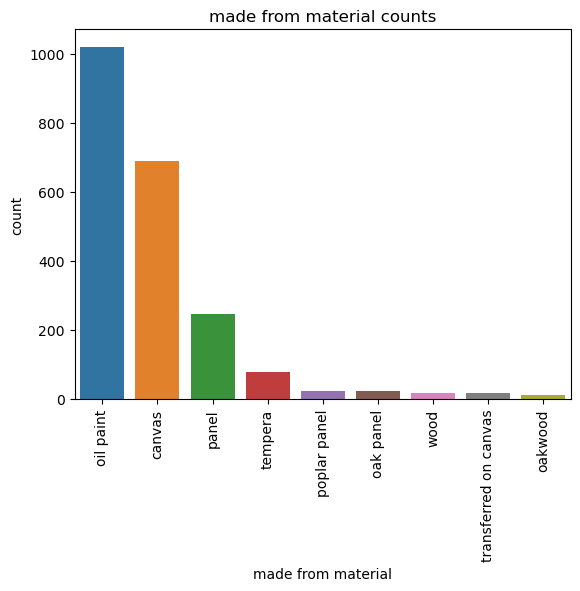

In [275]:
tmp = pd.DataFrame()
r = 'made from material'

tmp[r] = [k for k in movements_sorted]
tmp['count'] = [movements_sorted[k] for k in movements_sorted]
tmp = tmp[tmp['count']>8]
plt.xticks(rotation=90)
plt.title(r+' counts')
sns.barplot(data=tmp, x=r, y="count")

# Demo

In [495]:
url = "https://lh3.googleusercontent.com/ci/AA1T9HIalLIKg5EAI63qeL1n_cTJFm-4Ytxbrj70FtzblPhgT7UG6AbP6xEQck0D1EDBi_zVgy4AYQ=s1200"
abstract = ""

technique = 'image'
for r in relations:
    print('\tRELATION', r)
    if technique == 'image':
        prompts = [
        '''The following is a conversation between a curious human and an art historian assistant about paintings. The art historian gives helpful, detailed, and polite answers to the user's questions.
Human: <image>
Human: %s
Art Historian: '''%(prompt_dict[r])]
    elif technique == 'text':
        prompts = [
        '''The following is a conversation between a curious human and an art historian assistant about paintings. The art historian gives helpful, detailed, and polite answers to the user's questions.
Painting info: %s
Human: %s
Art Historian: '''%(abstract, prompt_dict[r])]

    elif technique == 'both':
        prompts = [
        '''The following is a conversation between a curious human and an art historian assistant about paintings. The art historian gives helpful, detailed, and polite answers to the user's questions.
Painting info: %s
Human: <image>
Human: %s
Art Historian: '''%(abstract, prompt_dict[r])]            
    # The image paths should be placed in the image_list and kept in the same order as in the prompts.
    # We support urls, local file paths and base64 string. You can custom the pre-process of images by modifying the mplug_owl.modeling_mplug_owl.ImageProcessor

    # generate kwargs (the same in transformers) can be passed in the do_generate()
    generate_kwargs = {
        'do_sample': True,
        'top_k': 5,
        'temperature':0.01,
        'max_length': 512
    }
    im = Image.open(urlopen(url))
    basewidth = 1024
    wpercent = (basewidth/float(im.size[0]))
    hsize = int((float(im.size[1])*float(wpercent)))
    img = im.resize((basewidth,hsize), Image.Resampling.LANCZOS)
    inputs = processor(text=prompts, images=[img], return_tensors='pt')
    inputs = {k: v.bfloat16() if v.dtype == torch.float else v for k, v in inputs.items()}
    inputs = {k: v.to(model.device) for k, v in inputs.items()}
    with torch.no_grad():
        res = model.generate(**inputs, **generate_kwargs)
    sentence = tokenizer.decode(res.tolist()[0], skip_special_tokens=True)
    print(sentence)

	RELATION creator
The painting was created by an unknown artist.
	RELATION movement
This painting belongs to the Baroque movement, which was a period of artistic expression that flourished in Europe from the late 16th to the early 18th century. The Baroque style is characterized by its dramatic, emotional, and exaggerated visual elements, often using vivid colors, intense lighting, and complex compositions. The painting features a man in a red robe, who is surrounded by a dog and a woman, both of whom are looking upwards. The scene is set in a room with a window, and the man is holding a sword. The overall composition and the use of lighting and color in the painting reflect the Baroque style.
